# Feature Engineering with Just Latitude and Longitude

# 0. Env

In [1]:
import numpy as np
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
import geohash2
# from sklearn.metrics import 

In [2]:
TRAIN_TEST_SPLIT_FRACTION = 0.8
MODEL_TARGET = "price_log1p"

# 1. Now Featuring... Latitude and Longitude!

### Load Data

Data taken from https://www.kaggle.com/datasets/kritikseth/us-airbnb-open-data

In [20]:
(
    pl.scan_csv("../data/AB_US_2023.csv")
    .select(pl.col("city").value_counts()).collect())

city
struct[2]
"{""Nashville"",8548}"
"{""Washington D.C."",6455}"
"{""Los Angeles"",42451}"
"{""Salem"",288}"
"{""Columbus"",2344}"
"{""Seattle"",6376}"
"{""Jersey City"",1314}"
"{""New Orleans"",7056}"
"{""San Francisco"",6936}"


In [21]:
df = (
    pl.scan_csv("../data/AB_US_2023.csv")
    .filter(pl.col("city") == "New York City")
    .select(pl.col(["latitude", "longitude", "price"]))
    .with_columns(pl.col("price").log1p().suffix("_log1p"))
#     .head(2500)
    .collect()
)

In [22]:
df = (
    df
    .with_row_count(name="row_number")
    .with_columns([
        (pl.col("row_number") < TRAIN_TEST_SPLIT_FRACTION * len(df)).alias("is_train")
    ])
)

### Brief Exploration

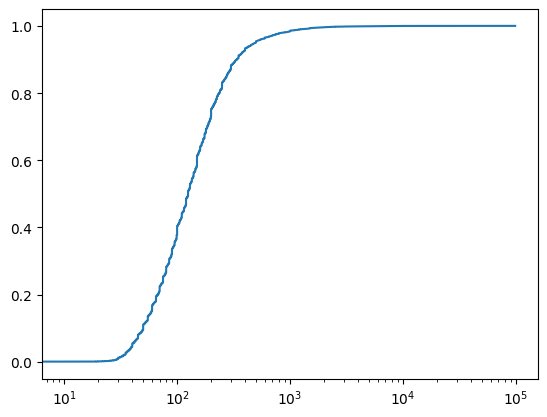

In [23]:
plt.plot(df["price"].sort(), np.linspace(0, 1, len(df)))
plt.xscale("log")
plt.show()

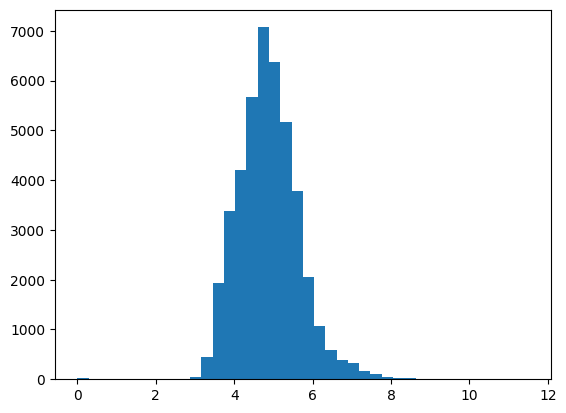

In [24]:
plt.hist(df["price_log1p"], bins=40)
plt.show()

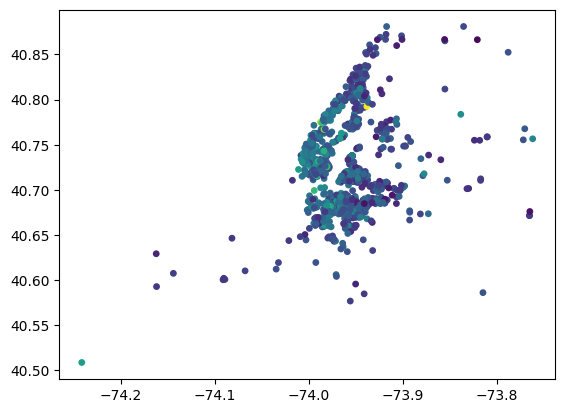

In [25]:
df_sample = df.head(1000)
plt.scatter(df_sample["longitude"], df_sample["latitude"], c=df_sample["price_log1p"], s=15, cmap="viridis")
plt.show()

In [26]:
df.select(["latitude", "longitude", "price"]).corr()

latitude,longitude,price
f64,f64,f64
1.0,0.046993,0.008133
0.046993,1.0,-0.058381
0.008133,-0.058381,1.0


## 1.1 Raw Latitude and Longitude

In [27]:
MODEL_FEATURE_LIST = ["latitude", "longitude"]

X_train = df.filter(pl.col("is_train")).select(MODEL_FEATURE_LIST)
y_train = df.filter(pl.col("is_train")).select(MODEL_TARGET)
X_test = df.filter(~pl.col("is_train")).select(MODEL_FEATURE_LIST)
y_test = df.filter(~pl.col("is_train")).select(MODEL_TARGET).to_numpy()

for model_name, model_class in zip(
    ["xgboost", "linear regression", "ridge regression"],
    [XGBRegressor, LinearRegression, Ridge]
):
    model = model_class().fit(X_train, y_train)
    y_predicted = model.predict(X_test)
    print(f"{model_name}, {mean_squared_error(y_test, y_predicted):.7f} (sklearn)")

xgboost, 0.5577219 (sklearn)
linear regression, 0.7237060 (sklearn)
ridge regression, 0.7238556 (sklearn)


## 1.2 Neighborhood Density

https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.cKDTree.query_ball_point.html#scipy.spatial.cKDTree.query_ball_point

## 1.3 Geohash category

In [28]:
geohash_precision = 5
df_geohash = (
    df.select(["latitude", "longitude"])
    .apply(
        lambda x: geohash2.encode(x[0], x[1], precision=geohash_precision)
    )
    .with_columns(pl.col("apply").alias(f"geohash_{geohash_precision}"))
)
df = df.with_columns(df_geohash.select(f"geohash_{geohash_precision}"))

In [29]:
n_unique_geohashes = df[f"geohash_{geohash_precision}"].n_unique()

In [30]:
one_hot_encoder = OneHotEncoder(sparse=False, drop="first")
one_hot_encoded_geohash_matrix = (
    one_hot_encoder
    .fit_transform(
        df[f"geohash_{geohash_precision}"].to_numpy().reshape(-1, 1)
    )
)
print(one_hot_encoded_geohash_matrix.shape)

(42931, 62)


/Users/benfeifke/code/personal-website/code/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [31]:
df = (
    df
    .with_columns(
        pl.col(f"geohash_{geohash_precision}")
        .cast(pl.Categorical)
        .to_physical()
        .alias(f"geohash_{geohash_precision}_label")
    )
)

In [32]:
X_train = one_hot_encoded_geohash_matrix[df["is_train"].to_numpy().astype(bool), :]
y_train = df.filter(pl.col("is_train")).select(MODEL_TARGET)
X_test = one_hot_encoded_geohash_matrix[~df["is_train"].to_numpy().astype(bool), :]
y_test = df.filter(~pl.col("is_train")).select(MODEL_TARGET).to_numpy()

for model_name, model_class in zip(
    ["xgboost", "linear regression", "ridge regression"],
    [XGBRegressor, LinearRegression, Ridge]
):
    model = model_class().fit(X_train, y_train)
    y_predicted = model.predict(X_test)
    print(f"{model_name}, {mean_squared_error(y_test, y_predicted):.7f} (sklearn)")

xgboost, 0.5860457 (sklearn)
linear regression, 0.5860618 (sklearn)
ridge regression, 0.5859651 (sklearn)


In [33]:
# MODEL_FEATURE_LIST = [f"geohash_{geohash_precision}_label"]

# X_train = df.filter(pl.col("is_train")).select(MODEL_FEATURE_LIST)
# y_train = df.filter(pl.col("is_train")).select(MODEL_TARGET)
# X_test = df.filter(~pl.col("is_train")).select(MODEL_FEATURE_LIST)
# y_test = df.filter(~pl.col("is_train")).select(MODEL_TARGET).to_numpy()

# for model_name, model_class in zip(
#     ["xgboost"],
#     [LGBMRegressor]
# ):
#     model = model_class().fit(X_train, y_train, categorical_feature=[0])
#     y_predicted = model.predict(X_test)
#     RMSE = np.sqrt(((y_predicted - y_test) ** 2).mean())
#     print(f"{model_name}, {RMSE:.7f}")

## 1.4 Geohash Target Encoding

In [34]:
df = (
    df
    .join(
        df
        .filter(pl.col("is_train"))
        .groupby(f"geohash_{geohash_precision}")
        .agg([
            pl.col("price").median().alias("geohash_price_median"),
            pl.col("price").max().alias("geohash_price_max"),
        ]),
        on="geohash_5",
        how="left"
    )
    .join(
        df
        # .filter(pl.col("is_train"))
        .groupby(f"geohash_{geohash_precision}")
        .agg([
            pl.col("price").count().alias("geohash_price_count"),
        ]),
        on="geohash_5",
        how="left"
    )
    
)

In [35]:
MODEL_FEATURE_LIST = [
    "geohash_price_count",
    "geohash_price_median",
    "geohash_price_max",
]

X_train = df.filter(pl.col("is_train") & pl.col("geohash_price_max").is_not_null()).select(MODEL_FEATURE_LIST)
y_train = df.filter(pl.col("is_train") & pl.col("geohash_price_max").is_not_null()).select(MODEL_TARGET)
X_test = df.filter(~pl.col("is_train") & pl.col("geohash_price_max").is_not_null()).select(MODEL_FEATURE_LIST)
y_test = df.filter(~pl.col("is_train") & pl.col("geohash_price_max").is_not_null()).select(MODEL_TARGET).to_numpy()

for model_name, model_class in zip(
    ["xgboost", "linear regression", "ridge regression"],
    [XGBRegressor, LinearRegression, Ridge]
):
    model = model_class().fit(X_train, y_train)
    y_predicted = model.predict(X_test)
    print(f"{model_name}, {mean_squared_error(y_test, y_predicted):.7f} (sklearn)")

xgboost, 0.5860619 (sklearn)
linear regression, 0.5849728 (sklearn)
ridge regression, 0.5849728 (sklearn)
